# Experimenting with Prescription Factor ($\mu$) 

This experiment is based off of Optimal Prescriptive Trees by Bertsimas, Dunn, and Mundru (2019). 

@article{bertsimas2019optimal,
  title={Optimal prescriptive trees},
  author={Bertsimas, Dimitris and Dunn, Jack and Mundru, Nishanth},
  journal={INFORMS Journal on Optimization},
  pages={ijoo--2018},
  year={2019},
  publisher={INFORMS}
}


I use the InterpretableAI Software
@misc{InterpretableAI,
  author = "Interpretable AI, LLC",
  title = "Interpretable AI Documentation",
  year = 2020,
  url = "https://www.interpretable.ai"
}




# Imports and Installs

In [ ]:
!/usr/bin/env python

In [19]:
#Must install matplotlib in Python 3
!pip3 install matplotlib

In [64]:
#Imports
import numpy as np
import pandas as pd
import random
from math import exp
import matplotlib.pyplot as plt
from operator import itemgetter
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import KFold

In [21]:
#Install the InterpretableAI package to Python
!pip install interpretableai

Note: you may need to restart the kernel to use updated packages.


In [22]:
#Import the software
import interpretableai
interpretableai.install(runtime='/Applications/Julia-1.5.app/Contents/Resources/julia/bin/julia')

In [23]:
#Import Julia to run InterpretableAI in Python
from julia import Julia
Julia(runtime='/Applications/Julia-1.5.app/Contents/Resources/julia/bin/julia', compiled_modules=False)  # and any other parameters as needed
from interpretableai import iai

# Generate Synthetic Data

This generation of data is used in Bertsimas et al. (2019) but originally described in "Some methods for heterogeneous treatment effect estimation in high-dimensions" by Powers et al. (2017).

In [24]:
#Denote a random seed
np.random.seed(123)
p = 10

#Generate the covariates of each sample with n being number of samples and p being the number of covariates
def generate_X(n, p):
    X = np.zeros((n, p))
    for j in range(p):
        if j % 2 == 0:
            X[:, j] = np.random.randn(n)
        else:
            X[:, j] = np.random.randint(0, 2, n)
    return pd.DataFrame(X, columns=["x" + str(j + 1) for j in range(p)])

In [25]:
#Define some treatment effect (Based off of the synthetic data generation in Bertsimas et al. (2019))
def treatment_effect(x):
    return (
        4 * (1 if x.x1 > 1 else 0) * (1 if x.x3 > 0 else 0) +
        4 * (1 if x.x5 > 1 else 0) * (1 if x.x7 > 0 else 0) +
        2 * x.x8 * x.x9
    )

#Generate outcomes for each treatment (Based off of the synthetic data generation in Bertsimas et al. (2019))
#There is yA which is the outcome for treatment A and yB which is the outcome for treatment B
def generate_outcomes(x):
    baseline = 10
    effect = treatment_effect(x)
    yA = baseline - 0.5 * effect
    yB = baseline + 0.5 * effect
    return yA, yB

In [ ]:
#Generate treatments and outcomes based on the treatments (Based off of the synthetic data generation in Bertsimas et al. (2019))

#This generates a randomly assigned treatment to a subject and the outcome that is observed for that treatment
#which is based on some probability calculated from the effects of the outcomes.
#all_outcomes contains the synthetic, known outcomes for the counterfactual treatments for each subject as well
#This is for oracle comparisons later

def generate_treatment_and_outcome(X):
    n = X.shape[0]
    assigned_treatments = np.zeros(n, dtype='object')
    assigned_outcomes = np.zeros(n)
    all_outcomes = np.zeros((n, 2))
    for i in range(n):
        all_outcomes[i, :] = generate_outcomes(X.iloc[i])
        outcomeA=all_outcomes[i,0]
        outcomeB=all_outcomes[i,1]
        effect = outcomeB - outcomeA
        prob = exp(effect) / (exp(effect) + 1)
        if np.random.rand() < prob:
            assigned_treatments[i] = "A"
            assigned_outcomes[i] = outcomeA
        else:
            assigned_treatments[i] = "B"
            assigned_outcomes[i] = outcomeB
        assigned_outcomes[i] += 0.2 * np.random.randn() #This adds a random noise to the outcomes of an assigned treatment
    return assigned_treatments, assigned_outcomes, all_outcomes


In [ ]:
#We generate n samples with covariates (X), assigned treatments, observed outcomes, and oracle counterfactual outcomes
n = 10000
X = generate_X(n, p)
treatments, outcomes, all_outcomes = generate_treatment_and_outcome(X)

In [ ]:
print(treatments) #example of treatment setup

In [ ]:
print(all_outcomes[1]) #example of oracle counterfactual outcomes

In [ ]:
print(outcomes[1]) #example of observed outcome (with noise)

In [ ]:
#Split data into training and testing for model fitting (80:20 split)
train_X, test_X, train_treatments, test_treatments, train_outcomes, test_outcomes, train_all_outcomes, test_all_outcomes = train_test_split(X, treatments, outcomes, all_outcomes, train_size=0.80, test_size=0.20)


# Defining Functions 

In [ ]:
#Define oracle that returns the best possible treatment and known outcome from the produced data
#We assume we are minimizing the outcome value
def oracle(X, outcomes):
    best_treatment = ['A' if outcomes[i, 0] < outcomes[i, 1] else 'B'
                      for i in range(X.shape[0])]
    best_outcome = [np.min(outcomes[i, :]) for i in range(X.shape[0])]
    
    return best_treatment, best_outcome

In [ ]:
#Define evaluate_outcomes function that computes the mean_squared error between the model predicted outcomes and the computed outcomes
#computed_outcomes should be predicted using oracle, knn_cf, or baseline functions

def evaluate_outcomes(grid, test_X, computed_outcomes):
    treatment_predictions, outcome_predictions = grid.predict(test_X)
    outcome_error = mean_squared_error(computed_outcomes, outcome_predictions)

    return outcome_error

In [ ]:
#Define evaluate_accuracy function that computes treatment and outcome accuracy based on the oracle treatments and outcomes
#This can be used to evaluate different models against the ground truth

def evaluate_accuracy(grid, X, computed_treatments, computed_outcomes):
    treatment_predictions, outcome_predictions = grid.predict(X)
    treatment_accuracy = np.mean(np.array(computed_treatments) ==
                                 np.array(treatment_predictions))
    outcome_accuracy = 1 - (np.sum((computed_outcomes - outcome_predictions) ** 2) /
                            np.sum((computed_outcomes - np.mean(computed_outcomes)) ** 2))

    return treatment_accuracy, outcome_accuracy
    


In [ ]:
#Define evaluate_mu to test 101 mu values between 0-1 and record the mu values and outcome_error values
#This can be used to see which is the most effective mu for the model based off of the outcome_error
#computed_outcomes should be predicted using oracle, knn_cf, or baseline functions
#Return list of mu values and list of outcome errors for each model OPT(mu)
def evaluate_mu(train_X, train_treatments, train_outcomes, test_X, computed_outcomes):
    mu_list=[]
    outcome_error_list=[]
    for i in range(0,101): #0-101
        mu=i/100
        grid = iai.GridSearch(  #Run OPT framework with mu value 
            iai.OptimalTreePrescriptionMinimizer(
                random_seed=1,
                prescription_factor=mu
            ),
            max_depth=range(1, 6),
        )
        grid.fit(train_X, train_treatments, train_outcomes)
        outcome_error = evaluate_outcomes(grid, test_X, computed_outcomes) #Test predicted model's outcomes versus the computed_outcomes
        mu_list.append(mu)
        outcome_error_list.append(outcome_error)
    return mu_list, outcome_error_list

#Define optimal_mu function to determine which mu has the least outcome_error
#This can be used to determine which mu to use for your model in further testing
#NOTE: If mu has multiple optimal values, it will just put the first one shown, but we can look at the data
def optimal_mu(mu_list, outcome_error_list): 
    index = min(enumerate(outcome_error_list), key=itemgetter(1))[0] 
    return mu_list[index]
        
#Define plot_mu_outcome_error to plot the outcome_error based on the mu value used in your model
#name is the name of your plot, and you can use this to name the y axis as well
def plot_mu_outcome_error(mu_list, outcome_error_list, name):
    plt.plot(mu_list, outcome_error_list)
    plt.xlabel('Mu value')
    plt.ylabel(name)
    plt.title(name)

    plt.show()

# Optimal Oracle $\mu$ Experiment 

I aim to train an optimal prescriptive tree that will minimize the outcome error of the training outcomes against the oracle outcomes. Then, I will plot the varying outcome error for the various $\mu$ values, and then will determine the optimal $\mu$ value based on the least outcome error.

In [ ]:
#Compute oracle treatments and outcomes for the test set
oracle_treatments, oracle_outcomes = oracle(test_X, test_all_outcomes)

In [ ]:
#Test the trained model with the testing set
#Evaluate mu by comparing predictions on the test set from your trained model against the oracle outcomes 
mu_list, oracle_outcome_error_list = evaluate_mu(train_X, train_treatments, train_outcomes, test_X, oracle_outcomes)

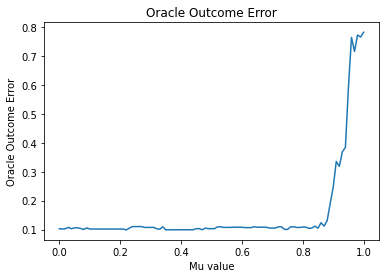

In [55]:
#Plot the outcome_error for each mu value for your oracle outcomes
plot_mu_outcome_error(mu_list, oracle_outcome_error_list, name="Oracle Outcome Error")

In [54]:
#Fine optimal mu based on the oracle outcome error
optimal_oracle_mu = optimal_mu(mu_list, oracle_outcome_error_list)
print("Optimal Oracle Mu is: ", optimal_oracle_mu)

Optimal Oracle Mu is:  0.22


# Optimal Baseline $\mu$ Experiment 

I aim to train an optimal prescriptive tree that will minimize the outcome error of the training outcomes against the baseline outcomes that were originally assigned. Then, I will plot the varying outcome error for the various $\mu$ values, and then will determine the optimal $\mu$ value based on the least outcome error.

In [57]:
#Baseline outcomes is just the test_outcomes that were observed
baseline_outcomes = test_outcomes

#Test the trained model with the testing set
#Evaluate mu by comparing predictions on the test set from your trained model against the baseline outcomes 
mu_list, bl_outcome_error_list = evaluate_mu(train_X, train_treatments, train_outcomes, test_X, baseline_outcomes)


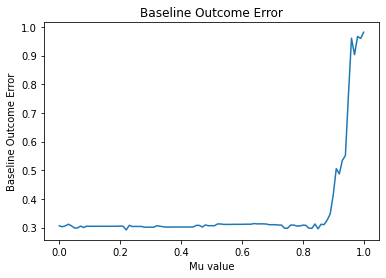

In [58]:
#Plot the outcome_error for each mu value for your baseline outcomes
plot_mu_outcome_error(mu_list, bl_outcome_error_list, name="Baseline Outcome Error")

In [59]:
#Fine optimal mu based on the baseline outcome error
optimal_baseline_mu = optimal_mu(mu_list, bl_outcome_error_list)
print("Optimal Baseline Mu is: ", optimal_baseline_mu)

Optimal Baseline Mu is:  0.22


# Optimal KNN-CF $\mu$ Experiment 

I aim to train an optimal prescriptive tree that will minimize the outcome error of the training outcomes against the counterfactual outcomes found by the KNN method. Then, I will plot the varying outcome error for the various $\mu$ values, and then will determine the optimal $\mu$ value based on the least outcome error.

In [201]:
#Define knn_counterfactuals function to calculate counterfactuals of the treatment outcomes 
#(Very convoluted, but I could not figure out how to split the data sets into the treatments in an easier way)

def knn_counterfactuals(test_X, test_treatments, test_outcomes):
    kf = KFold(n_splits=5) #Split data into 5 subsets to do cross validation
    kf.get_n_splits(test_X)
    knn_X = pd.DataFrame() #Declare a DataFrame to hold the X values in order as tested
    knn_all_outcomes = np.empty(shape=(0,2))
    for train_index, test_index in kf.split(X): #Loop to do cross validation
         
        #Make sure X, treatments, and outcomes are lined up for each index
        train_X, test_X = X.loc[train_index], X.loc[test_index] 
        train_treatments, test_treatments = treatments[train_index], treatments[test_index]
        train_outcomes, test_outcomes = outcomes[train_index], outcomes[test_index]
        
        #Line up the treatments and outcomes into the dataframes to keep track 
        train_X['train_treatments']=train_treatments
        train_X['train_outcomes']=train_outcomes
        test_X['test_treatments']=test_treatments
        test_X['test_outcomes']=test_outcomes

        #Split the training and testing data into the different treatments
        train_X_A=train_X[train_X['train_treatments']=='A']
        train_X_B=train_X[train_X['train_treatments']=='B']
        test_X_A=test_X[test_X['test_treatments']=='A']
        test_X_B=test_X[test_X['test_treatments']=='B']

        #Take the last columns as numpy arrays to hold treatments and outcomes
        train_treatments_A=train_X_A['train_treatments'].to_numpy(dtype=None)
        train_treatments_B=train_X_B['train_treatments'].to_numpy(dtype=None)
        test_treatments_A=test_X_A['test_treatments'].to_numpy(dtype=None)
        test_treatments_B=test_X_B['test_treatments'].to_numpy(dtype=None)
        train_outcomes_A=train_X_A['train_outcomes'].to_numpy(dtype=None)
        train_outcomes_B=train_X_B['train_outcomes'].to_numpy(dtype=None)
        test_outcomes_A=test_X_A['test_outcomes'].to_numpy(dtype=None)
        test_outcomes_B=test_X_B['test_outcomes'].to_numpy(dtype=None)

        #Drop the treatments and outcomes columns from the dataframe so X is just covariates again
        train_X_A.drop(columns=['train_treatments', 'train_outcomes'], inplace=True)
        train_X_B.drop(columns=['train_treatments', 'train_outcomes'], inplace=True)
        test_X_A.drop(columns=['test_treatments', 'test_outcomes'], inplace=True)
        test_X_B.drop(columns=['test_treatments', 'test_outcomes'], inplace=True)
        
        #Preprocess the data before running KNN
        lab_enc1 = preprocessing.LabelEncoder()
        lab_enc2 = preprocessing.LabelEncoder()
        train_outcomes_A_encoded = lab_enc1.fit_transform(train_outcomes_A)
        train_outcomes_B_encoded = lab_enc2.fit_transform(train_outcomes_B)

        #Train a modelA for treatment A
        modelA = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
        modelA.fit(train_X_A, train_outcomes_A_encoded)
        #Train a modelB for treatment B
        modelB = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
        modelB.fit(train_X_B, train_outcomes_B_encoded)
        
        #Using modelA to predict counterfactuals for X that previously was assigned treatment B and vice versa
        test_outcomes_BtoA = modelA.predict(test_X_B)
        test_outcomes_AtoB = modelB.predict(test_X_A)
        
        #Decode the outcomes
        test_outcomes_BtoA = lab_enc1.inverse_transform(test_outcomes_BtoA)
        test_outcomes_AtoB = lab_enc2.inverse_transform(test_outcomes_AtoB)
        
        #Add the samples with newly estimated counterfactuals into a dataframe for covariates and an array of paired outcomes
        knn_X = knn_X.append(test_X_A)
        knn_X = knn_X.append(test_X_B)
        test_all_outcomesA=np.zeros((len(test_X_A), 2))
        test_all_outcomesB=np.zeros((len(test_X_B), 2))
        for i in range(len(test_X_A)):
            test_all_outcomesA[i, 0] = test_outcomes_A[i]
            test_all_outcomesA[i, 1] = test_outcomes_AtoB[i]
        for i in range(len(test_X_B)):
            test_all_outcomesB[i, 0] = test_outcomes_B[i]
            test_all_outcomesB[i, 1] = test_outcomes_BtoA[i]
        knn_all_outcomes=np.vstack((knn_all_outcomes, test_all_outcomesA))
        knn_all_outcomes=np.vstack((knn_all_outcomes, test_all_outcomesB))
        
    #return the final list of all samples and their corresponding known outcomes and predicted counterfactuals
    return knn_X, knn_all_outcomes


In [202]:
#Compute the KNN-CF treatments and all-outcomes for the entire set 
knn_X, knn_all_outcomes = knn_counterfactuals(test_X, test_treatments, test_outcomes)

/Users/juliabalukonis/.julia/conda/3/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/juliabalukonis/.julia/conda/3/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/juliabalukonis/.julia/conda/3/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [203]:
#Compute best KNN-CF treatments and outcomes for the test set
knncf_treatments, knncf_outcomes = oracle(knn_X, knn_all_outcomes)

In [204]:
#Test the trained model with the testing set
#Evaluate mu by comparing predictions on the test set from your trained model against the knn_cf outcomes 

mu_list, knncf_outcome_error_list = evaluate_mu(train_X, train_treatments, train_outcomes, knn_X, knncf_outcomes)

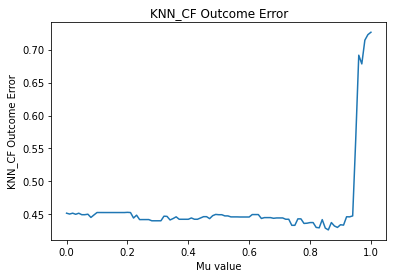

In [205]:
#Plot the outcome_error for each mu value for your knn_cf outcomes
plot_mu_outcome_error(mu_list, knncf_outcome_error_list, name="KNN_CF Outcome Error")

In [207]:
#Fine optimal mu based on the knn_cf outcome error
optimal_knncf_mu = optimal_mu(mu_list, knncf_outcome_error_list)
print("Optimal KNN_CF Mu is: ", optimal_knncf_mu)

Optimal KNN_CF Mu is:  0.86


# Optimal Cross-validated $\mu$'s Experiment 

I will find the cross-validated optimal $\mu$ using the IAI built-in functions.

In [208]:
#Calculate cross validated mu using IAI function with the criterion focused on prediction accuracy
grid = iai.GridSearch(
    iai.OptimalTreePrescriptionMinimizer(
        random_seed=1,
        max_depth=5,
    ),
    prescription_factor=np.linspace(0.0, 1.0, num=10), #Test 20 mu values between 0 and 1
)
grid.fit_cv(test_X, test_treatments, test_outcomes, validation_criterion='prediction_accuracy')
grid.get_best_params()

#Take the best mu based on the value of prediction accuracy from the recorded results
results_grid = grid.get_grid_results()
optimal_predcv_mu = results_grid.loc[results_grid['rank_valid_score'].idxmin()]['prescription_factor']

In [210]:
print("Optimal Predictive Mu is: ", optimal_predcv_mu)

Optimal Predictive Mu is:  0.5555555555555556


In [209]:
#Calculate cross validated mu using IAI function with the criterion focused on prescription outcome optimality
grid = iai.GridSearch(
    iai.OptimalTreePrescriptionMinimizer(
        random_seed=1,
        max_depth=5,
    ),
    prescription_factor=np.linspace(0.0, 1.0, num=10),
)
grid.fit_cv(test_X, test_treatments, test_outcomes, validation_criterion='prescription_outcome')
grid.get_best_params()

#Take the best mu based on the value of prescription outcome from the recorded results
results_grid = grid.get_grid_results()
optimal_prescv_mu = results_grid.loc[results_grid['rank_valid_score'].idxmin()]['prescription_factor']

In [211]:
print("Optimal Prescriptive Mu is: ", optimal_prescv_mu)

Optimal Prescriptive Mu is:  1.0


# Testing the Optimal $\mu$ values in the OPT

Here I test 100 realizations of the OPT($\mu$) with the various optimal $\mu$ values found previously. I plot the box plots of the treatment accuracy and outcome accuracy compared to the ground truth.

In [212]:
#TEST 100 CASES OF THE OPT(MU) for some mu value 
#Input the true known treatments and outcomes to compare model results
#Return treatment accuracy and outcome accuracy for the 100 realizations 
def opt(mu, train_X, train_treatments, train_outcomes, test_X, true_treatments, true_outcomes):
    treatment_acc_list, outcome_acc_list = [], []
    for i in range(1,101):
        grid = iai.GridSearch( 
            iai.OptimalTreePrescriptionMinimizer(
                random_seed=random.randint(1,1000),
                prescription_factor=mu,
                treatment_minbucket=1, #A treatment is assigned if there is one assigned sample 
            ),
            max_depth=range(1, 7),
        )
        grid.fit(train_X, train_treatments, train_outcomes)
        treatment_accuracy, outcome_accuracy = evaluate_accuracy(grid, test_X, true_treatments, true_outcomes)
        treatment_acc_list.append(treatment_accuracy)
        outcome_acc_list.append(outcome_accuracy)
    return treatment_acc_list, outcome_acc_list

#Test optimal $\mu$ values on the data and record treatment and outcome accuracy for each method.

In [217]:
oracle_treatment_acc_list, oracle_outcome_acc_list = opt(optimal_oracle_mu, train_X, train_treatments, train_outcomes, test_X, oracle_treatments, oracle_outcomes)

In [224]:
optimal_baseline_mu=0.75 #Since the mu was the same as the oracle, we will test the next best mu based on the graph
bl_treatment_acc_list, bl_outcome_acc_list = opt(optimal_baseline_mu, train_X, train_treatments, train_outcomes, test_X, oracle_treatments, oracle_outcomes)

In [219]:
knncf_treatment_acc_list, knncf_outcome_acc_list = opt(optimal_knncf_mu, train_X, train_treatments, train_outcomes, test_X, oracle_treatments, oracle_outcomes)

In [220]:
predcv_treatment_acc_list, predcv_outcome_acc_list = opt(optimal_predcv_mu, train_X, train_treatments, train_outcomes, test_X, oracle_treatments, oracle_outcomes)

In [221]:
prescv_treatment_acc_list, prescv_outcome_acc_list = opt(optimal_prescv_mu, train_X, train_treatments, train_outcomes, test_X, oracle_treatments, oracle_outcomes)

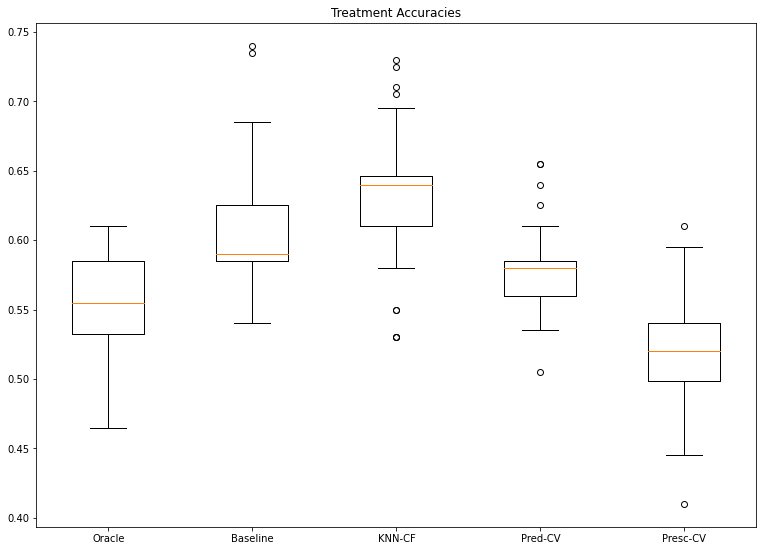

In [229]:
#Plot the treatment accuracy box plots for each method
treatment_acc_data = [oracle_treatment_acc_list, bl_treatment_acc_list, knncf_treatment_acc_list, predcv_treatment_acc_list, prescv_treatment_acc_list] 

fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_axes([0, 0, 1, 1]) 
bp = ax.boxplot(treatment_acc_data) 
plt.title("Treatment Accuracies")
plt.xticks([1,2,3,4,5],['Oracle', 'Baseline', 'KNN-CF', 'Pred-CV', 'Presc-CV'])

# show plot 
plt.show() 

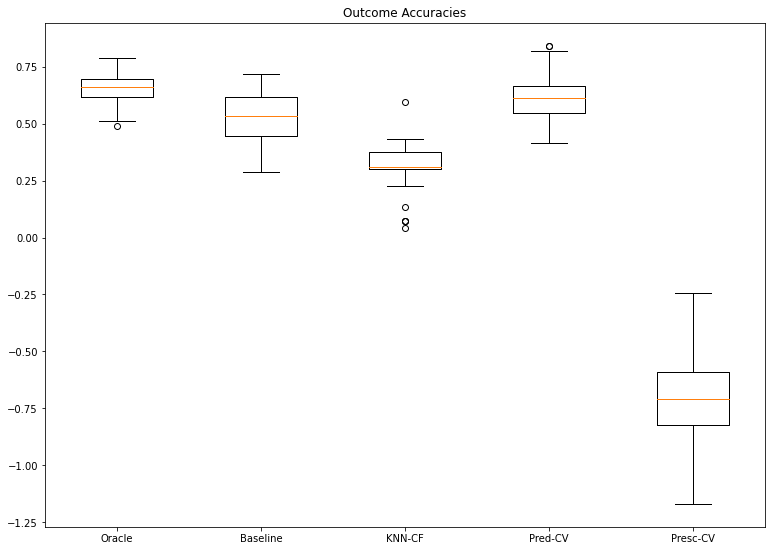

In [234]:
#Plot the outcome accuracy box plots for each method
outcome_acc_data = [oracle_outcome_acc_list, bl_outcome_acc_list, knncf_outcome_acc_list, predcv_outcome_acc_list, prescv_outcome_acc_list] 
  
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_axes([0, 0, 1, 1]) 
bp = ax.boxplot(outcome_acc_data) 

plt.title("Outcome Accuracies")
plt.xticks([1,2,3,4,5],['Oracle', 'Baseline', 'KNN-CF', 'Pred-CV', 'Presc-CV'])

# show plot 
plt.show() 